# Comparing CATE-BLP to Naive Interactive Linear Model 

In [13]:
# Setup
library(blpopt)
library(grf)
library(tidyr)
library(dplyr)
library(ggplot2)

theme_set(theme_minimal())

## Compare with 1 simulation

In [14]:
# Simulate data
n <- 2000
p <- 20
X <- matrix(rnorm(n * p), n, p)

# CATE varies along one dim only.
tau_ex <- function(x) {
  1 / (1 + exp(-x))
}
TAU <- tau_ex(X[, 3])

# Propensity  and Outcome vary along 2 and 5 dimensions only.
W <- rbinom(n, 1, 1 / (1 + exp(-X[, 1] - X[, 2])))
Y <- pmax(X[, 2] + X[, 3], 0) + rowMeans(X[, 4:6]) / 2 + W * TAU + rnorm(n)

In [15]:
# Predict from simple interactive linear model
lm_fitted <- lm(Y ~ X[,c(1:2, 4:p)] + W * TAU)

lm_pred <- data.frame(lm_predicted =
                          (lm_fitted$coefficients["W"] +
                               lm_fitted$coefficients["TAU"] * TAU +
                               (lm_fitted$coefficients["W:TAU"] * TAU)) -
                          lm_fitted$coefficients["TAU"] * TAU)

In [16]:
# CATE-BLP
cf <- causal_forest(X, Y, W)
blp <- cate_blp(cf, X[, 3])

blp_pred <- predict(blp)

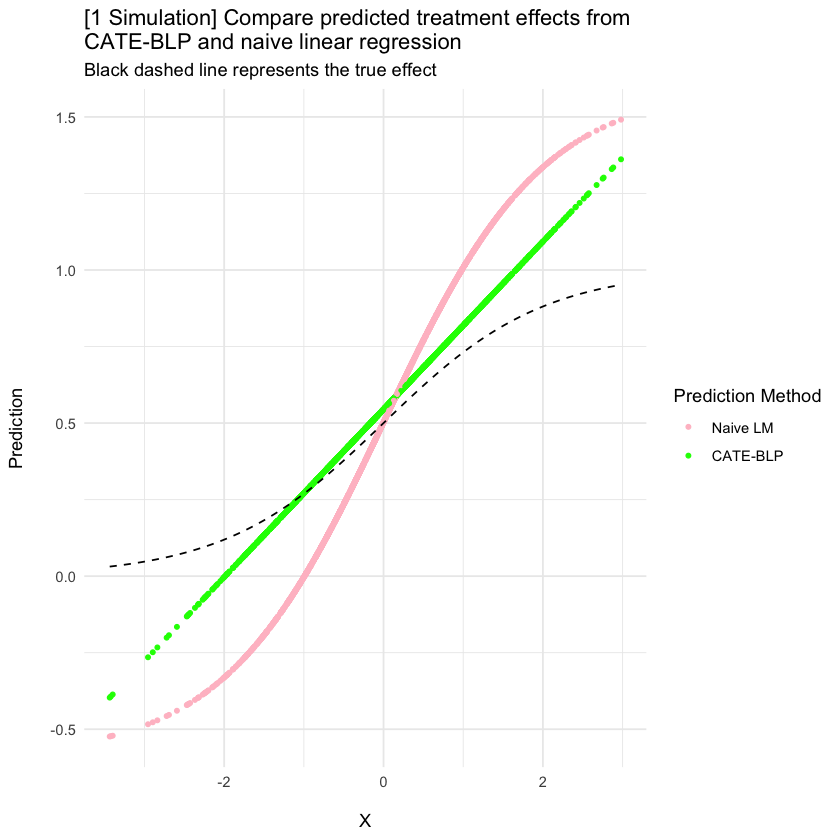

In [17]:
# Combine into one data frame
comb_df <- cbind(blp_pred, lm_pred) %>%
    pivot_longer(cols = 2:3, names_to = "type",
    values_to = "prediction")
comb_df$type <- factor(comb_df$type, labels = c("Naive LM", "CATE-BLP"))

# Visually compare predictions
ggplot(comb_df, aes(x = A, y = prediction, color = type)) +
  geom_point(size = 1) +
  geom_function(fun = tau_ex, col = "black", linetype = "dashed") +
  scale_color_manual(values = c("pink", "green"), name = "Prediction Method") +
  xlab("\nX") + ylab("Prediction\n") +
  ggtitle("[1 Simulation] Compare predicted treatment effects from\nCATE-BLP and naive linear regression ",
    subtitle = "Black dashed line represents the true effect")


## Compare using 100 simulations

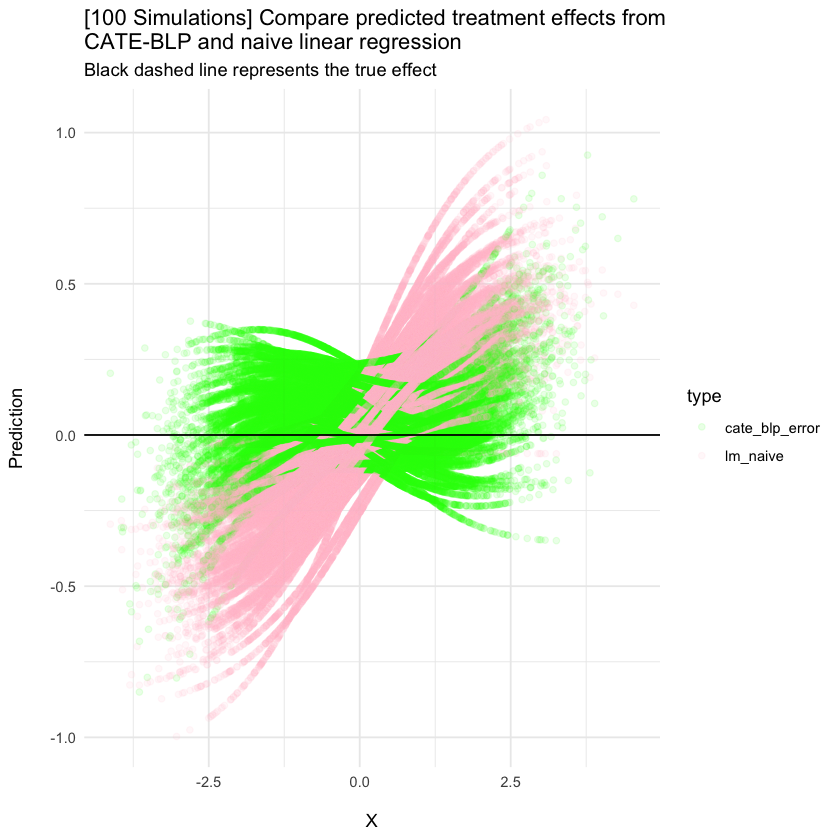

In [18]:
sim_diff <- function(n = 1000){
  # Simulate data
  p <- 20
  X <- matrix(rnorm(n * p), n, p)

  # CATE varies along one dim only.
  tau_ex <- function(x) {
    1 / (1 + exp(-x))
  }
  TAU <- tau_ex(X[, 3])

  # Propensity  and Outcome vary along 2 and 5 dimensions only.
  W <- rbinom(n, 1, 1 / (1 + exp(-X[, 1] - X[, 2])))
  Y <- pmax(X[, 2] + X[, 3], 0) + rowMeans(X[, 4:6]) / 2 + W * TAU + rnorm(n)

  # Predict from simple lm
  lm_fitted <- lm(Y ~ X[,c(1:2, 4:p)] + W * TAU)

  lm_pred <- data.frame(lm_predicted =
                            (lm_fitted$coefficients["W"] +
                                lm_fitted$coefficients["TAU"] * TAU +
                                (lm_fitted$coefficients["W:TAU"] * TAU)) -
                            lm_fitted$coefficients["TAU"] * TAU)

  # CATE-BLP
  cf <- causal_forest(X, Y, W)
  blp <- cate_blp(cf, X[, 3])

  blp_pred <- predict(blp)

  comb <- list(A = blp_pred$A,
                        cate_blp_error = blp_pred$predicted - TAU,
                        lm_naive = lm_pred$lm_predicted - TAU)
  comb
}

sims <- replicate(100, sim_diff(), simplify = FALSE)

sims_df <- dplyr::bind_rows(sims)
sims_df <- pivot_longer(sims_df, cols=2:3, names_to = "type",
                         values_to = "prediction_error")

#sims_df$error_diff <- sims_df$cate_blp_error - sims_df$lm_naive

ggplot(sims_df, aes(x = A, y = prediction_error, color = type)) +
    geom_point(alpha = 0.1) +
    geom_hline(yintercept = 0) +
    scale_color_manual(values = c("green", "pink")) +
    xlab("\nX") + ylab("Prediction\n") +
    ggtitle("[100 Simulations] Compare predicted treatment effects from\nCATE-BLP and naive linear regression ",
            subtitle = "Black dashed line represents the true effect")